In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import losses, optimizers, metrics
import numpy as np              # numpy to work with tensors (with tf)
import matplotlib.pyplot as plt # function to show images
%matplotlib inline
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm_notebook

   

In [2]:
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   210k      0 --:--:-- --:--:-- --:--:--  210k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  37.3M      0 --:--:-- --:--:-- --:--:-- 37.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  54722      0 --:--:-- --:--:-- --:--:-- 55390
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  8751k      0 --:--:-- --:--:-- --:--:-- 8751k


In [3]:
!gunzip t*-ubyte.gz

gzip: t10k-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: t10k-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: train-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: train-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [2]:
X_train, y_train = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train_6k = X_train.copy()[:6000]/255.0
y_train_6k = y_train.copy()[:6000]
X_train_12k = X_train.copy()[:12000]/255.0
y_train_12k = y_train.copy()[:12000]
X_test = X_test[:1000]/255.0
y_test = y_test[:1000]

In [3]:
noise = 0.25 #25% noise

bern = np.random.binomial(1,noise, len(y_train_6k))
s = sum(bern)
y_train_noise_6k = y_train_6k.copy()
y_train_noise_6k[bern==1] = np.random.randint(9,size=s)

bern = np.random.binomial(1,noise, len(y_train_12k))
s = sum(bern)
y_train_noise_12k = y_train_12k.copy()
y_train_noise_12k[bern==1] = np.random.randint(9,size=s)

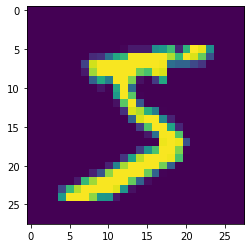

In [4]:
plt.imshow(X_train_6k[0].reshape(28,28))

In [5]:
y_train_6k[0]

5

In [6]:
y_train_6k = tf.keras.utils.to_categorical(y_train_6k)
y_train_12k = tf.keras.utils.to_categorical(y_train_12k)
y_train_noise_6k = tf.keras.utils.to_categorical(y_train_noise_6k)
y_train_noise_12k = tf.keras.utils.to_categorical(y_train_noise_12k)

y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
y_train_6k[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [8]:
#blocks definition
#input_size = 32 #ONLY FOR CIFAR DATASET
input_size = 28
def cnn_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,pooling=2):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.MaxPool2D(pool_size=(pooling,pooling))(x)
    return x


def resnet_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,r=True):    
    x = K.layers.BatchNormalization()(x_inp)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    if r:
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x


def resnet(k=64):
    images = K.layers.Input((input_size,input_size, 1))
    x = resnet_block(images,k,strides=1)
    n_blocks = 4
    for i in range(1, n_blocks):
            x = resnet_block(x, k* (2**i),strides=2)   
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)


def cnn(k=64):
    images = K.layers.Input((input_size,input_size, 1))
    x = cnn_block(images,k,pooling=1)
    n_blocks = 4
    for i in range(1, n_blocks):
        if i == 3:
            x = cnn_block(x, k* (2**i),pooling=4) 
            #x = cnn_block(x, k * (2**i),pooling=8) only for CIFAR DATASET   
        else:
            x = cnn_block(x, k * (2**i))
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)

In [9]:
cnn_net = cnn(64)
cnn_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512   

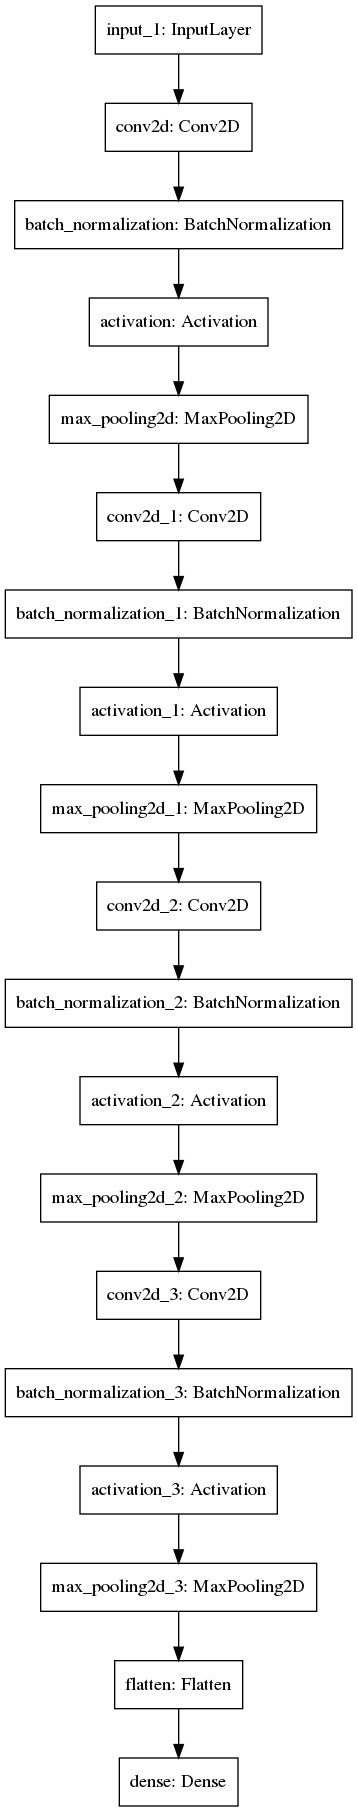

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_net, to_file='cnn_model.png')

In [11]:
res_net = resnet(64)
res_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 28, 28, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 28, 28, 1)    0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   640         activation_4[0][0]               
____________________________________________________________________________________________

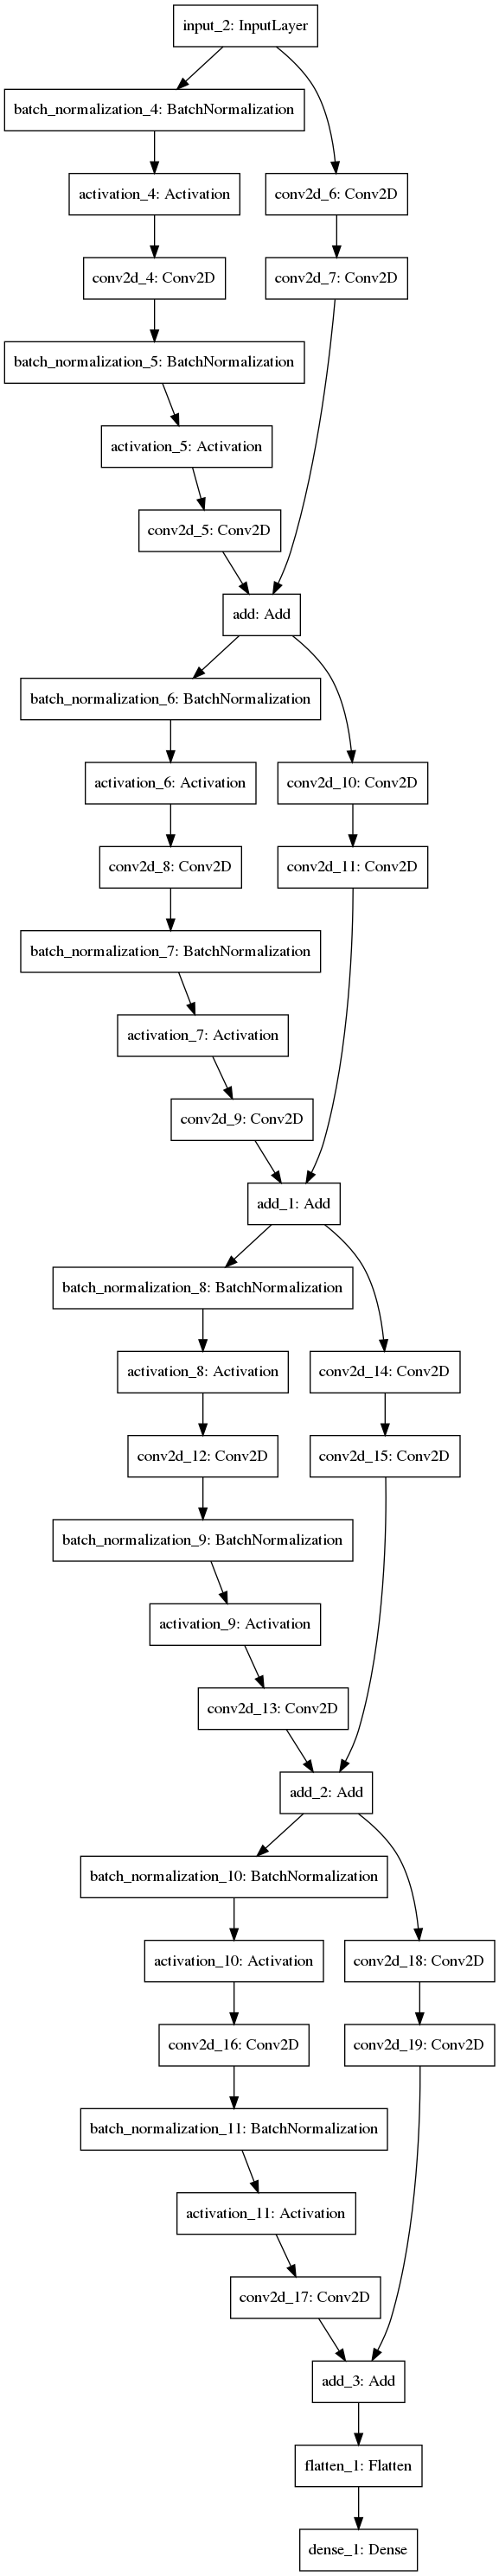

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(res_net, to_file='resnet_model.png')

## MODEL-WISE DOUBLE DESCENT

In [0]:
train_loss_noiseless = {}
test_loss_noiseless = {}
train_loss_noise = {}
test_loss_noise = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_noiseless = []
    error_test_noiseless = []
    error_train_noise = []
    error_test_noise = []
    s = '-'
    for _ in range(3):
    #noiseless
    net = cnn(k)
    net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
    history = net.fit(X_train_6k,y_train_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
    error_train_noiseless.append(history.history['loss'][-1])
    error_test_noiseless.append(history.history['val_loss'][-1])
    #noise
    net = cnn(k)
    net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
    history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
    error_train_noise.append(history.history['loss'][-1])
    error_test_noise.append(history.history['val_loss'][-1])
    train_loss_noiseless[k] = np.mean(error_train_noiseless)
    test_loss_noiseless[k] = np.mean(error_test_noiseless)
    train_loss_noise[k] = np.mean(error_train_noise)
    test_loss_noise[k] = np.mean(error_test_noise)

    if k > 1:
    if list(test_loss_noiseless.values())[-1] >= list(test_loss_noiseless.values())[-2]:
        s = '+'
    else:
        s = '-'
    print('NOISELESS: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noiseless[k],4),round(test_loss_noiseless[k],4),s))
    if k > 1:
    if list(test_loss_noise.values())[-1] >= list(test_loss_noise.values())[-2]:
        s = '+'
    else:
        s = '-'
    print('25% NOISE: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noise[k],4),round(test_loss_noise[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


NOISELESS: k: 1, train_loss: 0.2183, test_loss: 0.3422 // -
25% NOISE: k: 1, train_loss: 1.2479, test_loss: 0.7111 // -




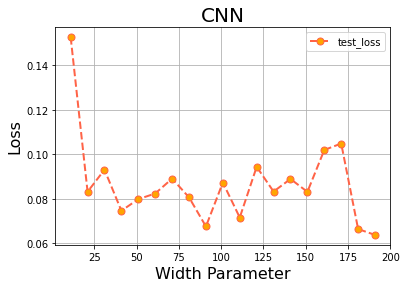

In [48]:
# multiple line plot
plt.figure(figsize=(20,16)
plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='Noiseless')
plt.plot(list(test_loss_noise.keys()),list(test_loss_noise.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='25% Noise')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN model_wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## SAMLE-WISE DOUBLE DESCENT

In [35]:
train_loss_6k = {}
test_loss_6k = {}
train_loss_12k = {}
test_loss_12k = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_6k = []
    error_test_6k = []
    error_train_12k = []
    error_test_12k = []
    s = '-'
    for _ in range(3):
        #6k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_6k.append(history.history['loss'][-1])
        error_test_6k.append(history.history['val_loss'][-1])
        #12k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_12k,y_train_noise_12k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_12k.append(history.history['loss'][-1])
        error_test_12k.append(history.history['val_loss'][-1])
    train_loss_6k[k] = np.mean(error_train_6k)
    test_loss_6k[k] = np.mean(error_test_6k)
    train_loss_12k[k] = np.mean(error_12k)
    test_loss_12k[k] = np.mean(error_12k)

    if k > 1:
        if list(test_loss_6k.values())[-1] >= list(test_loss_6k.values())[-2]:
            s = '+'
        else:
            s = '-'
        print('6k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_6k[k],4),round(test_loss_6k[k],4),s))
    if k > 1:
        if list(test_loss_12k.values())[-1] >= list(test_loss_12k.values())[-2]:
            s = '+'
        else:
            s = '-'
        print('12k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_12k[k],4),round(test_loss_12k[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1, train_loss: 1.5658, test_loss: 2.1765 // -
Epoch: 6, train_loss: 0.6369, test_loss: 1.4408 // -
Epoch: 11, train_loss: 0.1651, test_loss: 1.0805 // -
Epoch: 16, train_loss: 0.1302, test_loss: 1.2243 // +
Epoch: 21, train_loss: 0.0311, test_loss: 1.2326 // +
Epoch: 26, train_loss: 0.0039, test_loss: 1.146 // -
Epoch: 31, train_loss: 0.0004, test_loss: 1.0041 // -
Epoch: 36, train_loss: 0.0003, test_loss: 1.009 // +
Epoch: 41, train_loss: 0.0001, test_loss: 1.0176 // +
Epoch: 46, train_loss: 0.0002, test_loss: 0.9921 // -
Epoch: 51, train_loss: 0.0001, test_loss: 1.2103 // +
Epoch: 56, train_loss: 0.0001, test_loss: 1.0473 // -
Epoch: 61, train_loss: 0.0, test_loss: 1.01 // -
Epoch: 66, train_loss: 0.0001, test_loss: 1.0715 // +
Epoch: 71, train_loss: 0.0, test_loss: 1.0154 // -
Epoch: 76, train_loss: 0.0, test_loss: 1.1253 // +


KeyboardInterrupt: ignored

In [0]:
# multiple line plot
plt.figure(figsize=(20,16)
plt.plot(list(test_loss_6k.keys()),list(test_loss_6k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='6k samples')
plt.plot(list(test_loss_12k.keys()),list(test_loss_12k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='12k samples')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN model_wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## EPOCH-WISE DOUBLE DESCENT

In [52]:
train_loss = {}
test_loss = {}
for k in [3,12,48]
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,150,5)):
    error_train = []
    error_test = []
    s = '-'
    for _ in range(3):
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train,y_train,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
        error_train.append(history.history['loss'][-1])
        error_test.append(history.history['val_loss'][-1])
    train_loss[k][e] = np.mean(error_train)
    test_loss[k][e] = np.mean(error_test)
    if e > 1:
        if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
            s = '+'
        else:
            s = '-'
    print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[e],4),round(test_loss[e],4),s))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1, train_loss: 1.7276, test_loss: 2.2902 // -
Epoch: 11, train_loss: 0.6402, test_loss: 0.9338 // -
Epoch: 21, train_loss: 0.2704, test_loss: 0.7121 // -
Epoch: 31, train_loss: 0.0447, test_loss: 0.4972 // -
Epoch: 41, train_loss: 0.0152, test_loss: 0.4846 // -
Epoch: 51, train_loss: 0.0067, test_loss: 0.4808 // -
Epoch: 61, train_loss: 0.0038, test_loss: 0.4263 // -
Epoch: 71, train_loss: 0.0022, test_loss: 0.435 // +
Epoch: 81, train_loss: 0.0018, test_loss: 0.537 // +
Epoch: 91, train_loss: 0.0012, test_loss: 0.4954 // -
Epoch: 101, train_loss: 0.0009, test_loss: 0.5737 // +
Epoch: 111, train_loss: 0.0008, test_loss: 0.5434 // -
Epoch: 121, train_loss: 0.0005, test_loss: 0.5768 // +
Epoch: 131, train_loss: 0.0004, test_loss: 0.4369 // -
Epoch: 141, train_loss: 0.0003, test_loss: 0.5195 // +
Epoch: 151, train_loss: 0.0002, test_loss: 0.5565 // +
Epoch: 161, train_loss: 0.0002, test_loss: 0.6104 // +
Epoch: 171, train_loss: 0.0001, test_loss: 0.5578 // -
Epoch: 181, train_loss:

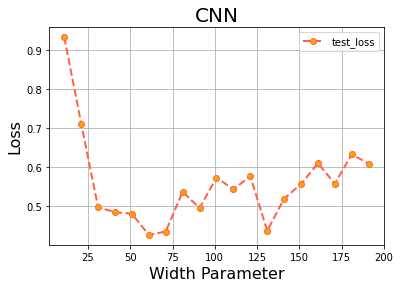

In [54]:
#multiple line plot
plt.figure(figsize=(20,16)
plt.plot(list(test_loss[3].keys()),list(test_loss[3].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='k=3')
plt.plot(list(test_loss[12].keys()),list(test_loss[12].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='blue', color='purple', linewidth=2,markersize=12,label='k=12')
plt.plot(list(test_loss[48].keys())[1:],list(test_loss[48].values())[1:],'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()